<a href="https://colab.research.google.com/github/flambye94/FL_Towards_Robust_PrivacySec/blob/main/FLFabienSechi_DAT945.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import, Fetch URLs, Preprocess

In [ ]:
pip install seaborn

## IMPORT

In [ ]:
import pandas as pd
import numpy as np
import requests
import sys
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Concatenate, Reshape, Dropout, Softmax

## URL KDD-NSL

In [ ]:
# URL references
urls = {
    "field_names": "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/Field%20Names.csv",
    "train_data": 'https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.csv',
    "test_data": 'https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest%2B.csv',
    "attack_types": "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/Attack%20Types.csv"
}

## DATA FETCHING

In [ ]:
# Data fetching and preprocessing
try:
    url = urls["field_names"]
    kdd_names_df = pd.read_csv(url, header=None)
    kdd_cols = kdd_names_df[0].str.split(':', expand=True)[0].str.strip().tolist()
    kdd_cols += ['class', 'difficulty']
except Exception as e:
    print(f"Error fetching field names: {e}")
    sys.exit(1)

try:
    kdd = pd.read_csv(urls["train_data"], header=None)
    kdd_t = pd.read_csv(urls["test_data"], header=None)
except pd.errors.EmptyDataError as e:
    print(f"No data: {e}")
    sys.exit(1)
except pd.errors.ParserError as e:
    print(f"Error parsing data: {e}")
    sys.exit(1)
except Exception as e:
    print(f"An error occurred during data fetching: {e}")
    sys.exit(1)

print("kdd",kdd,"kdd_t",kdd_t)
# Fetching attack map and replacing class labels
try:
    response = requests.get(urls["attack_types"])
    response_content = response.text.replace('\r', '\n')
    lines = [x.strip().split(',') for x in response_content.split('\n') if x]
    attack_map = {k: v for k, v in lines}
except Exception as e:
    print(f"Error fetching attack map: {e}")
    sys.exit(1)

kdd         0    1         2   3     4     5   6   7   8   9   ...    33    34  \
0        0  tcp  ftp_data  SF   491     0   0   0   0   0  ...  0.17  0.03   
1        0  udp     other  SF   146     0   0   0   0   0  ...  0.00  0.60   
2        0  tcp   private  S0     0     0   0   0   0   0  ...  0.10  0.05   
3        0  tcp      http  SF   232  8153   0   0   0   0  ...  1.00  0.00   
4        0  tcp      http  SF   199   420   0   0   0   0  ...  1.00  0.00   
...     ..  ...       ...  ..   ...   ...  ..  ..  ..  ..  ...   ...   ...   
125968   0  tcp   private  S0     0     0   0   0   0   0  ...  0.10  0.06   
125969   8  udp   private  SF   105   145   0   0   0   0  ...  0.96  0.01   
125970   0  tcp      smtp  SF  2231   384   0   0   0   0  ...  0.12  0.06   
125971   0  tcp    klogin  S0     0     0   0   0   0   0  ...  0.03  0.05   
125972   0  tcp  ftp_data  SF   151     0   0   0   0   0  ...  0.30  0.03   

          35    36    37    38    39    40       41  42  
0

## DATA  PREPROCESSING


In [ ]:
# Assign column names
kdd.columns = kdd_cols
kdd_t.columns = kdd_cols

# Applying attack map to dataframes
kdd['class'] = kdd['class'].replace(attack_map)
kdd_t['class'] = kdd_t['class'].replace(attack_map)

# Function definitions for data processing
def cat_encode(df, col):
    return pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col].values, prefix=col)], axis=1)

def log_trns(df, col):
    return df[col].apply(np.log1p)

# Data processing
cat_lst = ['protocol_type', 'service', 'flag']
for col in cat_lst:
    kdd = cat_encode(kdd, col)
    kdd_t = cat_encode(kdd_t, col)

log_lst = ['duration', 'src_bytes', 'dst_bytes']
for col in log_lst:
    kdd[col] = log_trns(kdd, col)
    kdd_t[col] = log_trns(kdd_t, col)

# Align columns in test set to match training set
kdd, kdd_t = kdd.align(kdd_t, axis=1, fill_value=0)

# Splitting data into features and labels
difficulty = kdd.pop('difficulty')
target = kdd.pop('class')
y_diff = kdd_t.pop('difficulty')
y_test = kdd_t.pop('class')

# One-hot encoding the target variables
target = pd.get_dummies(target)
y_test = pd.get_dummies(y_test)

# Correcting column mismatches in y_test
df = pd.DataFrame(y_test)
y_test = df[['dos', 'normal', 'probe','r2l', 'u2r']]

# Converting dataframes to numpy arrays
target = target.values
train = kdd.values
test = kdd_t.values
y_test = y_test.values

# Scaling features
min_max_scaler = MinMaxScaler()
train = min_max_scaler.fit_transform(train)
test = min_max_scaler.transform(test)



#Simple Model and evaluation without FL

In [ ]:

# Building the model
def create_model_KERAS():
    input = Input(shape=(122,))
    x = Dense(64)(input)
    x = Dense(32)(x)
    x = Activation('relu')(x)
    x = Dropout(.15)(x)
    x = Dense(32)(x)
    x = Activation('relu')(x)
    x = Dropout(.15)(x)
    x = Dense(32)(x)
    x = Activation('relu')(x)
    x = Dropout(.15)(x)
    x = Dense(5)(x)
    output = Softmax(axis=-1)(x)

    model = Model(inputs=input, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

KNN = create_model_KERAS()
KNN.summary()


# Implementing early stopping
early_stopping = EarlyStopping(patience=6)

# Model training
try:
    KNN.fit(x=train, y=target, epochs=100, validation_split=0.1, batch_size=128, callbacks=[early_stopping])
except ValueError as e:
    print(f"Value error during model training: {e}")
    sys.exit(1)
except MemoryError as e:
    print(f"Memory error during model training: {e}")
    sys.exit(1)
except Exception as e:
    print(f"An error occurred during model training: {e}")
    sys.exit(1)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 122)]             0         
                                                                 
 dense (Dense)               (None, 64)                7872      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 activation (Activation)     (None, 32)                0         
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 activation_1 (Activation)   (None, 32)                0     

In [ ]:
pip install visualkeras --upgrade


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 6.6 MB/s eta 0:00:00


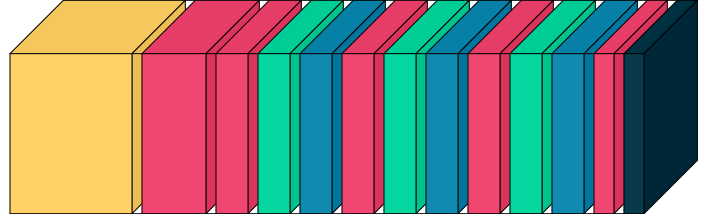

In [ ]:
import visualkeras

visualkeras.layered_view(KNN, to_file='output.png', scale_xy=0.1, min_xy= 160, scale_z=1) # write to disk


In [ ]:
# Model evaluation
y_pred = KNN.predict(test)
y_pred_class = np.argmax(y_pred, axis=1)
y_test_class = np.argmax(y_test, axis=1)

# Confusion matrix and f1-score
confusion_mtx = confusion_matrix(y_test_class, y_pred_class)
f1 = f1_score(y_test_class, y_pred_class, average='weighted')

print("Confusion Matrix:")
print(confusion_mtx)
print(f"F1 Score: {f1}")

705/705 [==============================] - 3s 3ms/step
Confusion Matrix:
[[6055 2617  671  148    0]
 [ 441 9045  222    2    0]
 [   0    3 1103    0    0]
 [   3 1876    2  318    0]
 [   0   34    0    2    1]]
F1 Score: 0.7116898169896885


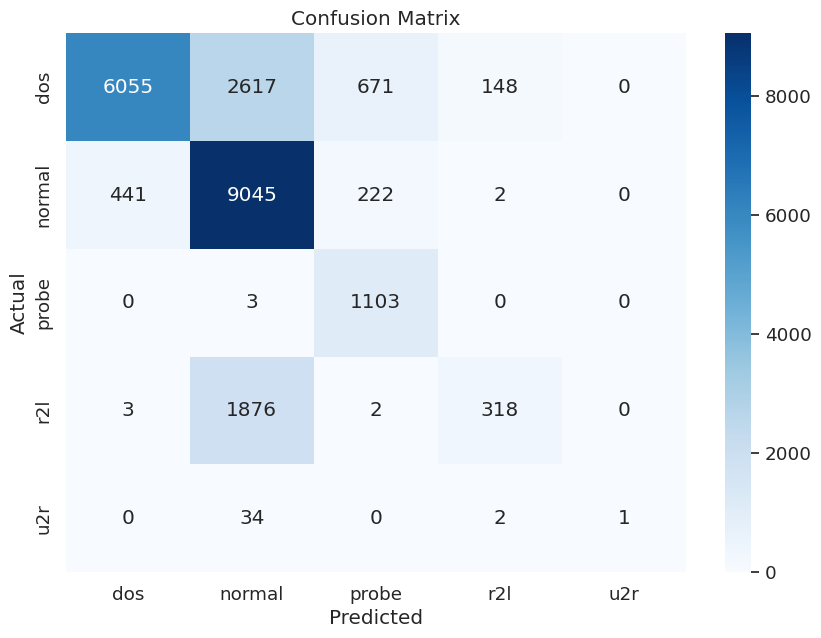

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the labels for your classes
labels = ['dos', 'normal', 'probe', 'r2l', 'u2r']

# Create the heatmap using Seaborn
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.2)
sns.heatmap(confusion_mtx, annot=True, fmt="g", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# DUMMY FEDERATED LEARNING MODEL CREATION

Re-run the Import, Fetch URLs, Preprocess section for each of the sub- section bellow

In [ ]:
import pandas as pd
import numpy as np
import requests
import sys
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Concatenate, Reshape, Dropout, Softmax

# URL references
urls = {
    "field_names": "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/Field%20Names.csv",
    "train_data": 'https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.csv',
    "test_data": 'https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest%2B.csv',
    "attack_types": "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/Attack%20Types.csv"
}

# Data fetching and preprocessing
try:
    url = urls["field_names"]
    kdd_names_df = pd.read_csv(url, header=None)
    kdd_cols = kdd_names_df[0].str.split(':', expand=True)[0].str.strip().tolist()
    kdd_cols += ['class', 'difficulty']
except Exception as e:
    print(f"Error fetching field names: {e}")
    sys.exit(1)

try:
    kdd = pd.read_csv(urls["train_data"], header=None)
    kdd_t = pd.read_csv(urls["test_data"], header=None)
except pd.errors.EmptyDataError as e:
    print(f"No data: {e}")
    sys.exit(1)
except pd.errors.ParserError as e:
    print(f"Error parsing data: {e}")
    sys.exit(1)
except Exception as e:
    print(f"An error occurred during data fetching: {e}")
    sys.exit(1)

print("kdd",kdd,"kdd_t",kdd_t)
# Fetching attack map and replacing class labels
try:
    response = requests.get(urls["attack_types"])
    response_content = response.text.replace('\r', '\n')
    lines = [x.strip().split(',') for x in response_content.split('\n') if x]
    attack_map = {k: v for k, v in lines}
except Exception as e:
    print(f"Error fetching attack map: {e}")
    sys.exit(1)

    # Assign column names
kdd.columns = kdd_cols
kdd_t.columns = kdd_cols

# Applying attack map to dataframes
kdd['class'] = kdd['class'].replace(attack_map)
kdd_t['class'] = kdd_t['class'].replace(attack_map)

# Function definitions for data processing
def cat_encode(df, col):
    return pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col].values, prefix=col)], axis=1)

def log_trns(df, col):
    return df[col].apply(np.log1p)

# Data processing
cat_lst = ['protocol_type', 'service', 'flag']
for col in cat_lst:
    kdd = cat_encode(kdd, col)
    kdd_t = cat_encode(kdd_t, col)

log_lst = ['duration', 'src_bytes', 'dst_bytes']
for col in log_lst:
    kdd[col] = log_trns(kdd, col)
    kdd_t[col] = log_trns(kdd_t, col)

# Align columns in test set to match training set
kdd, kdd_t = kdd.align(kdd_t, axis=1, fill_value=0)

# Splitting data into features and labels
difficulty = kdd.pop('difficulty')
target = kdd.pop('class')
y_diff = kdd_t.pop('difficulty')
y_test = kdd_t.pop('class')

# One-hot encoding the target variables
target = pd.get_dummies(target)
y_test = pd.get_dummies(y_test)

# Correcting column mismatches in y_test
df = pd.DataFrame(y_test)
y_test = df[['dos', 'normal', 'probe','r2l', 'u2r']]

# Converting dataframes to numpy arrays
target = target.values
train = kdd.values
test = kdd_t.values
y_test = y_test.values

# Scaling features
min_max_scaler = MinMaxScaler()
train = min_max_scaler.fit_transform(train)
test = min_max_scaler.transform(test)

kdd         0    1         2   3     4     5   6   7   8   9   ...    33    34  \
0        0  tcp  ftp_data  SF   491     0   0   0   0   0  ...  0.17  0.03   
1        0  udp     other  SF   146     0   0   0   0   0  ...  0.00  0.60   
2        0  tcp   private  S0     0     0   0   0   0   0  ...  0.10  0.05   
3        0  tcp      http  SF   232  8153   0   0   0   0  ...  1.00  0.00   
4        0  tcp      http  SF   199   420   0   0   0   0  ...  1.00  0.00   
...     ..  ...       ...  ..   ...   ...  ..  ..  ..  ..  ...   ...   ...   
125968   0  tcp   private  S0     0     0   0   0   0   0  ...  0.10  0.06   
125969   8  udp   private  SF   105   145   0   0   0   0  ...  0.96  0.01   
125970   0  tcp      smtp  SF  2231   384   0   0   0   0  ...  0.12  0.06   
125971   0  tcp    klogin  S0     0     0   0   0   0   0  ...  0.03  0.05   
125972   0  tcp  ftp_data  SF   151     0   0   0   0   0  ...  0.30  0.03   

          35    36    37    38    39    40       41  42  
0

## 2 clients with sequential model on 5 rounds -> KERAS MODEL



In [ ]:
from keras.models import clone_model

# Step 1: Split the dataset
train_data_split_1 = train[:int(train.shape[0] * 0.5)]
train_data_split_2 = train[int(train.shape[0] * 0.5):]

train_labels_split_1 = target[:int(target.shape[0] * 0.5)]
train_labels_split_2 = target[int(target.shape[0] * 0.5):]


# Step 2: Create a model template
def create_model_KERAS():
    input = Input(shape=(122,))
    x = Dense(64)(input)
    x = Dense(32)(x)
    x = Activation('relu')(x)
    x = Dropout(.15)(x)
    x = Dense(32)(x)
    x = Activation('relu')(x)
    x = Dropout(.15)(x)
    x = Dense(32)(x)
    x = Activation('relu')(x)
    x = Dropout(.15)(x)
    x = Dense(5)(x)
    output = Softmax(axis=-1)(x)

    model = Model(inputs=input, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# Step 2: Initialize models for both clients
model_1 = create_model_KERAS()
model_2 = create_model_KERAS()

# Step 3: Train models and average weights for a number of rounds
n_rounds = 5
for round in range(n_rounds):
    print(f"Round {round+1}/{n_rounds}")

    # Train models on their respective data splits
    model_1.fit(train_data_split_1, train_labels_split_1, epochs=1, batch_size=32, verbose=0)
    model_2.fit(train_data_split_2, train_labels_split_2, epochs=1, batch_size=32, verbose=0)

    # Calculate the average weights
    weights_1 = model_1.get_weights()
    weights_2 = model_2.get_weights()
    avg_weights = [(w1 + w2)/2 for w1, w2 in zip(weights_1, weights_2)]

    # Set the average weights to both models
    model_1.set_weights(avg_weights)
    model_2.set_weights(avg_weights)

# Step 4: Test the final model on the testing dataset
loss, accuracy = model_1.evaluate(test, y_test, verbose=0)
print(f"Final test loss: {loss:.4f}")
print(f"Final test accuracy: {accuracy:.4f}")



Round 1/5
Round 2/5
Round 3/5
Round 4/5
Round 5/5
Final test loss: 1.2889
Final test accuracy: 0.7500


705/705 [==============================] - 3s 4ms/step
Confusion Matrix for Federated Learning Model:
[[6513 2208  747   23    0]
 [ 429 9044  236    1    0]
 [   0    5 1101    0    0]
 [   0 1949    1  249    0]
 [   0   33    0    4    0]]
F1 Score for Federated Learning Model: 0.7267006887683265


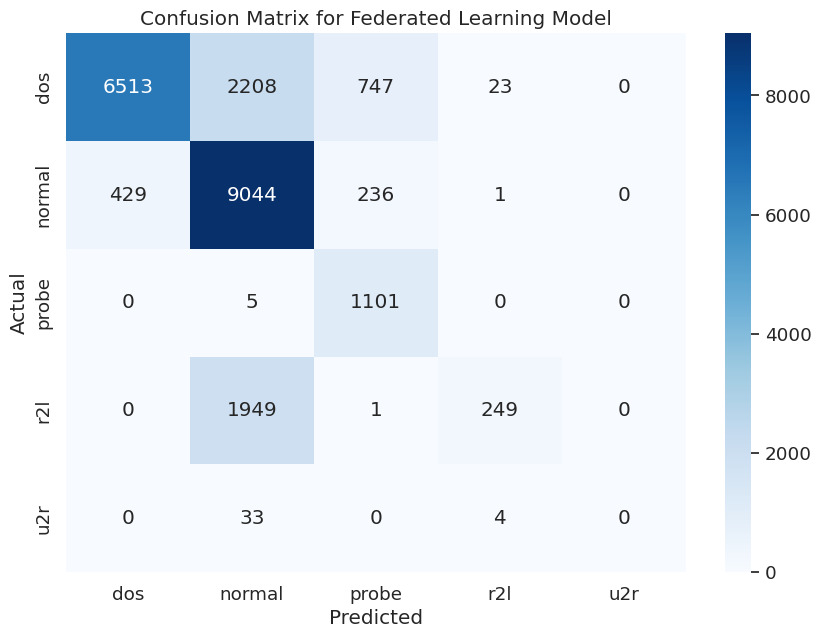

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Model evaluation for federated learning model
y_pred_fed = model_1.predict(test)
y_pred_fed_class = np.argmax(y_pred_fed, axis=1)
y_test_class = np.argmax(y_test, axis=1)

# Confusion matrix and f1-score for federated learning model
confusion_mtx_fed = confusion_matrix(y_test_class, y_pred_fed_class)
f1_fed = f1_score(y_test_class, y_pred_fed_class, average='weighted')

print("Confusion Matrix for Federated Learning Model:")
print(confusion_mtx_fed)
print(f"F1 Score for Federated Learning Model: {f1_fed}")

# Plotting confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.2)
# Define the labels for your classes
labels = ['dos', 'normal', 'probe', 'r2l', 'u2r']
sns.heatmap(confusion_mtx_fed, annot=True, fmt="g", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Federated Learning Model')
plt.show()


## 5 clients with my original model on 10 rounds -> KERAS MODEL




In [ ]:
def split_data(data, labels, num_clients):
    """Splits data and labels into num_clients parts."""
    client_data = []
    data_size = len(data) // num_clients
    for i in range(num_clients):
        data_start = i * data_size
        data_end = (i + 1) * data_size if i != num_clients - 1 else None
        client_data.append((data[data_start:data_end], labels[data_start:data_end]))
    return client_data

# Split data among N clients
num_clients = 5  # specify your N value here
client_data = split_data(train, target, num_clients)

# Step 2: Create a model template
def create_model_KERAS():
    input = Input(shape=(122,))
    x = Dense(64)(input)
    x = Dense(32)(x)
    x = Activation('relu')(x)
    x = Dropout(.15)(x)
    x = Dense(32)(x)
    x = Activation('relu')(x)
    x = Dropout(.15)(x)
    x = Dense(32)(x)
    x = Activation('relu')(x)
    x = Dropout(.15)(x)
    x = Dense(5)(x)
    output = Softmax(axis=-1)(x)
    model = Model(inputs=input, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Initialize models for all clients
models = [create_model_KERAS() for _ in range(num_clients)]

# Train models and average weights for a number of rounds
n_rounds = 10
for round in range(n_rounds):
    print(f"Round {round+1}/{n_rounds}")

    # Train models on their respective data splits
    for i in range(num_clients):
        models[i].fit(client_data[i][0], client_data[i][1], epochs=1, batch_size=32, verbose=0)

    # Calculate the average weights
    avg_weights = [sum(weights)/num_clients for weights in zip(*[model.get_weights() for model in models])]

    # Set the average weights to all models
    for model in models:
        model.set_weights(avg_weights)

# Test the final model on the testing dataset
loss, accuracy = models[0].evaluate(test, y_test, verbose=0)
print(f"Final test loss: {loss:.4f}")
print(f"Final test accuracy: {accuracy:.4f}")

Round 1/10
Round 2/10
Round 3/10
Round 4/10
Round 5/10
Round 6/10
Round 7/10
Round 8/10
Round 9/10
Round 10/10
Final test loss: 1.4482
Final test accuracy: 0.7377


705/705 [==============================] - 2s 3ms/step
Confusion Matrix for Federated Learning Model:
[[6416 2420  629   26    0]
 [ 457 9053  200    0    0]
 [   0    5 1101    0    0]
 [   0 2140    0   59    0]
 [   0   36    0    1    0]]
F1 Score for Federated Learning Model: 0.7045644090052778


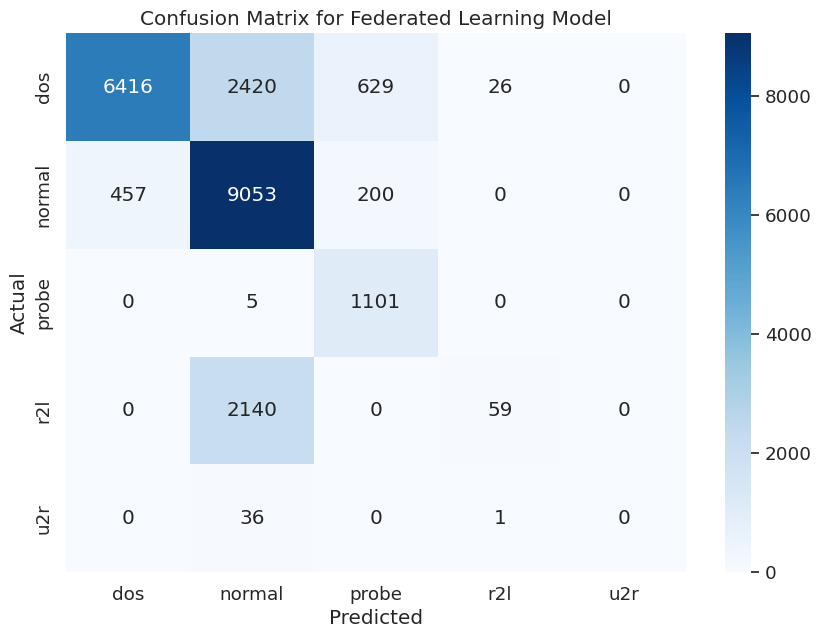

In [ ]:
# Model evaluation for federated learning model
y_pred_fed = models[0].predict(test)
y_pred_fed_class = np.argmax(y_pred_fed, axis=1)

# Confusion matrix and f1-score for federated learning model
confusion_mtx_fed = confusion_matrix(y_test_class, y_pred_fed_class)
f1_fed = f1_score(y_test_class, y_pred_fed_class, average='weighted')

print("Confusion Matrix for Federated Learning Model:")
print(confusion_mtx_fed)
print(f"F1 Score for Federated Learning Model: {f1_fed}")

# Plotting confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.2)
# Define the labels for your classes
labels = ['dos', 'normal', 'probe', 'r2l', 'u2r']

sns.heatmap(confusion_mtx_fed, annot=True, fmt="g", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Federated Learning Model')
plt.show()


## 5 clients with my original model on 10 rounds + dummy Fernet encryption -> KERAS MODEL




In [ ]:
# Define a stub for a function that "encrypts" a model's weights
from cryptography.fernet import Fernet
import numpy as np
import pickle

# Generate a key and instantiate a Fernet instance
key = Fernet.generate_key()
cipher_suite = Fernet(key)

def encrypt_weights(weights):
    # Pickle the list of numpy arrays
    weights_pickle = pickle.dumps(weights)

    # Encrypt the pickled data
    encrypted_weights = cipher_suite.encrypt(weights_pickle)

    return encrypted_weights

def decrypt_weights(encrypted_weights):
    # Decrypt the weights
    decrypted_weights_pickle = cipher_suite.decrypt(encrypted_weights)
    # Unpickle the bytes back to a list of numpy arrays
    decrypted_weights = pickle.loads(decrypted_weights_pickle)
    return decrypted_weights

def split_data(data, labels, num_clients):
    """Splits data and labels into num_clients parts."""
    client_data = []
    data_size = len(data) // num_clients
    for i in range(num_clients):
        data_start = i * data_size
        data_end = (i + 1) * data_size if i != num_clients - 1 else None
        client_data.append((data[data_start:data_end], labels[data_start:data_end]))
    return client_data

# Split data among N clients
num_clients = 5  # specify your N value here
client_data = split_data(train, target, num_clients)

# Step 2: Create a model template
def create_model_KERAS():
    input = Input(shape=(122,))
    x = Dense(64)(input)
    x = Dense(32)(x)
    x = Activation('relu')(x)
    x = Dropout(.15)(x)
    x = Dense(32)(x)
    x = Activation('relu')(x)
    x = Dropout(.15)(x)
    x = Dense(32)(x)
    x = Activation('relu')(x)
    x = Dropout(.15)(x)
    x = Dense(5)(x)
    output = Softmax(axis=-1)(x)
    model = Model(inputs=input, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Initialize models for all clients
models = [create_model_KERAS() for _ in range(num_clients)]

# Train models and average weights for a number of rounds
n_rounds = 10
for round in range(n_rounds):
    print(f"Round {round+1}/{n_rounds}")

    encrypted_weights_list = []
    for i in range(num_clients):
        # Train each client's model on their respective data splits
        models[i].fit(client_data[i][0], client_data[i][1], epochs=1, batch_size=32, verbose=0)

        # Encrypt the weights before sending them to the server
        encrypted_weights = encrypt_weights(models[i].get_weights())
        encrypted_weights_list.append(encrypted_weights)

    # Decrypt and average the weights at the server
    avg_weights = [sum(weights)/num_clients for weights in zip(*[decrypt_weights(ew) for ew in encrypted_weights_list])]

    # Set the average weights to all models
    for model in models:
        model.set_weights(avg_weights)

# Test the final model on the testing dataset
loss, accuracy = models[0].evaluate(test, y_test, verbose=0)
print(f"Final test loss: {loss:.4f}")
print(f"Final test accuracy: {accuracy:.4f}")

Round 1/10
Round 2/10
Round 3/10
Round 4/10
Round 5/10
Round 6/10
Round 7/10
Round 8/10
Round 9/10
Round 10/10
Final test loss: 1.5595
Final test accuracy: 0.7482


705/705 [==============================] - 1s 854us/step
Confusion Matrix for Federated Learning Model:
[[6619 2220  637   15    0]
 [ 424 9090  195    1    0]
 [   0    5 1101    0    0]
 [   0 2039    0  160    0]
 [   0   31    0    6    0]]
F1 Score for Federated Learning Model: 0.7248137222043785


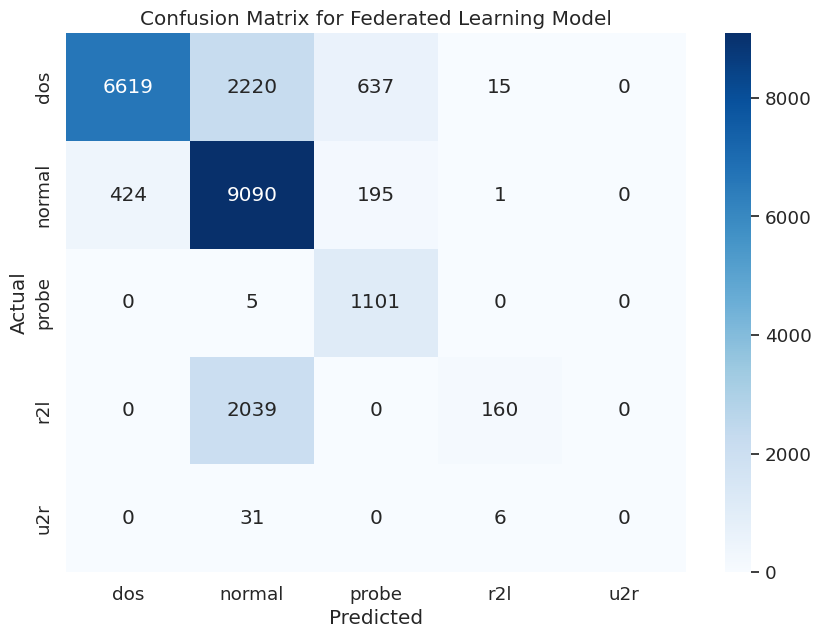

In [ ]:
# Model evaluation for federated learning model
y_pred_fed = models[0].predict(test)
y_pred_fed_class = np.argmax(y_pred_fed, axis=1)

# Confusion matrix and f1-score for federated learning model
confusion_mtx_fed = confusion_matrix(y_test_class, y_pred_fed_class)
f1_fed = f1_score(y_test_class, y_pred_fed_class, average='weighted')

print("Confusion Matrix for Federated Learning Model:")
print(confusion_mtx_fed)
print(f"F1 Score for Federated Learning Model: {f1_fed}")

# Plotting confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.2)
sns.heatmap(confusion_mtx_fed, annot=True, fmt="g", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Federated Learning Model')
plt.show()


## 10 clients with sequential model on 10 rounds -> KERAS MODEL

In [ ]:
def split_data(data, labels, num_clients):
    """Splits data and labels into num_clients parts."""
    client_data = []
    data_size = len(data) // num_clients
    for i in range(num_clients):
        data_start = i * data_size
        data_end = (i + 1) * data_size if i != num_clients - 1 else None
        client_data.append((data[data_start:data_end], labels[data_start:data_end]))
    return client_data

# Split data among N clients
num_clients = 10  # specify N value here
client_data = split_data(train, target, num_clients)

# Step 2: Create a model template
def create_model_KERAS():
    input = Input(shape=(122,))
    x = Dense(64)(input)
    x = Dense(32)(x)
    x = Activation('relu')(x)
    x = Dropout(.15)(x)
    x = Dense(32)(x)
    x = Activation('relu')(x)
    x = Dropout(.15)(x)
    x = Dense(32)(x)
    x = Activation('relu')(x)
    x = Dropout(.15)(x)
    x = Dense(5)(x)
    output = Softmax(axis=-1)(x)
    model = Model(inputs=input, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Initialize models for all clients
models = [create_model_KERAS() for _ in range(num_clients)]

# Train models and average weights for a number of rounds
n_rounds = 10
for round in range(n_rounds):
    print(f"Round {round+1}/{n_rounds}")

    # Train models on their respective data splits
    for i in range(num_clients):
        models[i].fit(client_data[i][0], client_data[i][1], epochs=1, batch_size=32, verbose=0)

    # Calculate the average weights
    avg_weights = [sum(weights)/num_clients for weights in zip(*[model.get_weights() for model in models])]

    # Set the average weights to all models
    for model in models:
        model.set_weights(avg_weights)

# Test the final model on the testing dataset
loss, accuracy = models[0].evaluate(test, y_test, verbose=0)
print(f"Final test loss: {loss:.4f}")
print(f"Final test accuracy: {accuracy:.4f}")

Round 1/10
Round 2/10
Round 3/10
Round 4/10
Round 5/10
Round 6/10
Round 7/10
Round 8/10
Round 9/10
Round 10/10
Final test loss: 1.0721
Final test accuracy: 0.7439


705/705 [==============================] - 1s 1ms/step
Confusion Matrix for Federated Learning Model:
[[6611 2203  677    0    0]
 [ 451 9072  187    0    0]
 [   0   20 1086    0    0]
 [   0 2199    0    0    0]
 [   1   36    0    0    0]]
F1 Score for Federated Learning Model: 0.7074273716827285


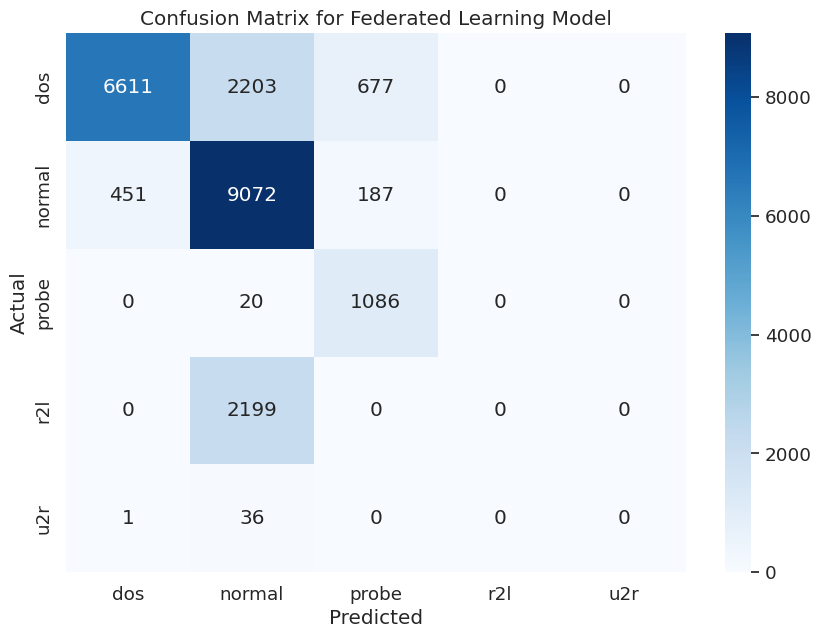

In [ ]:
# Model evaluation for federated learning model
y_pred_fed = models[0].predict(test)
y_pred_fed_class = np.argmax(y_pred_fed, axis=1)

# Confusion matrix and f1-score for federated learning model
confusion_mtx_fed = confusion_matrix(y_test_class, y_pred_fed_class)
f1_fed = f1_score(y_test_class, y_pred_fed_class, average='weighted')

print("Confusion Matrix for Federated Learning Model:")
print(confusion_mtx_fed)
print(f"F1 Score for Federated Learning Model: {f1_fed}")

# Plotting confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.2)
sns.heatmap(confusion_mtx_fed, annot=True, fmt="g", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Federated Learning Model')
plt.show()


# Cleverhans and attack make the model stronger

In [ ]:
pip install cleverhans

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 10.2 MB/s eta 0:00:00


In [ ]:
from cleverhans.tf2.attacks import fast_gradient_method
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Activation, Dropout, Softmax
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `models[0]` is the final model after federated learning
final_modelA = models[0]
final_modelB = models[0]
final_modelC = models[0]
final_modelD = models[0]
epsilon = 0.3  # You can adjust epsilon to control the magnitude of the attack


705/705 [==============================] - 2s 2ms/step
Confusion Matrix Before Attack:
[[5696 2888  907    0    0]
 [ 400 9124  186    0    0]
 [  59   45 1002    0    0]
 [   1 2198    0    0    0]
 [   0   37    0    0    0]]
F1 Score Before Attack: 0.6647155421344113


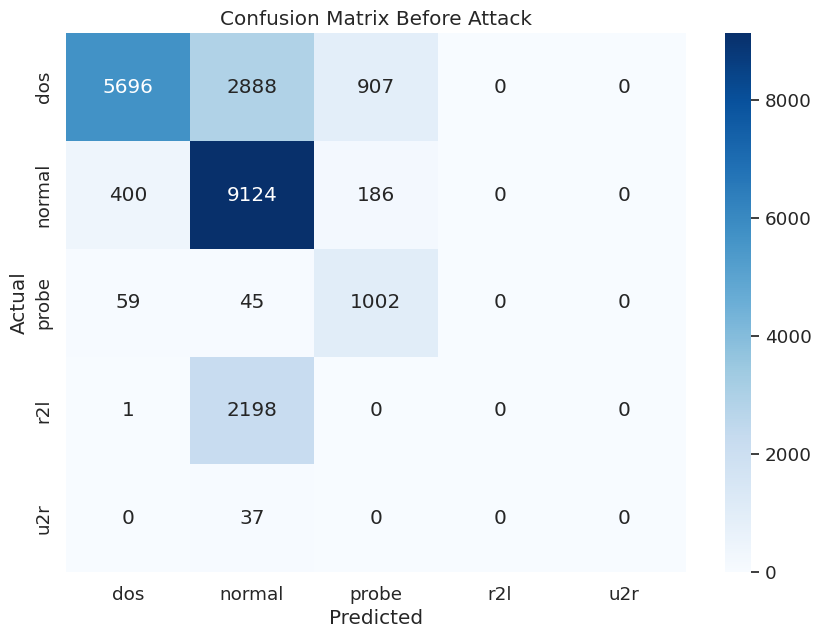

705/705 [==============================] - 1s 1ms/step
Confusion Matrix After Attack:
[[2969 6300  222    0    0]
 [ 172 9487   51    0    0]
 [ 581  432   93    0    0]
 [  49 2145    5    0    0]
 [   8   29    0    0    0]]
F1 Score After Attack: 0.48538641050204473


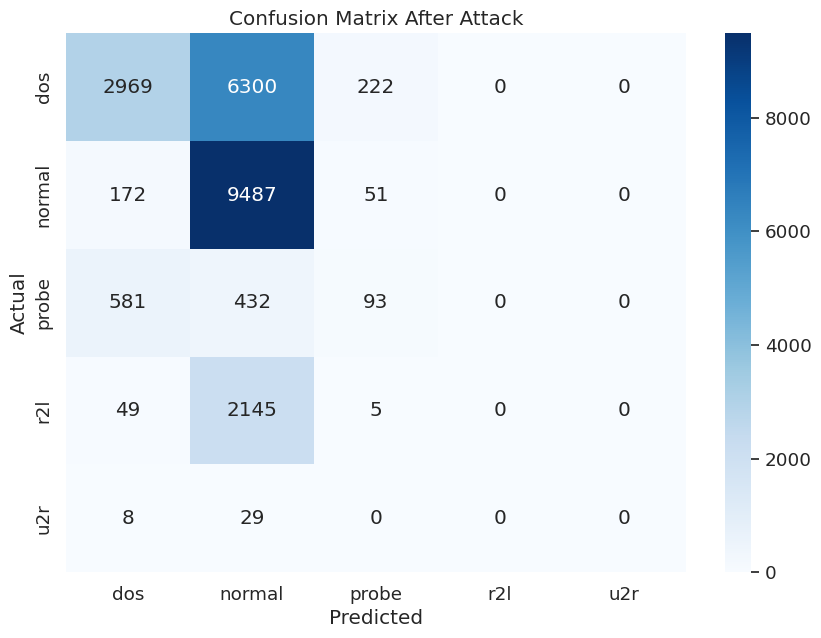

In [ ]:
# Convert test data to TensorFlow tensors
test_images_tf = tf.convert_to_tensor(test, dtype=tf.float32)
test_labels_tf = tf.convert_to_tensor(y_test, dtype=tf.float32)

# True class labels
y_test_class = np.argmax(test_labels_tf, axis=1)

# Predict class labels for original test data
y_pred_original = final_modelA.predict(test_images_tf)
y_pred_original_class = np.argmax(y_pred_original, axis=1)

# Compute confusion matrix and F1 score before attack
confusion_mtx_before = confusion_matrix(y_test_class, y_pred_original_class)
f1_before = f1_score(y_test_class, y_pred_original_class, average='weighted')

print("Confusion Matrix Before Attack:")
print(confusion_mtx_before)
print(f"F1 Score Before Attack: {f1_before}")

# Define labels
labels = ['dos', 'normal', 'probe', 'r2l', 'u2r']

# Plotting confusion matrix using Seaborn (Before Attack)
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.2)
sns.heatmap(confusion_mtx_before, annot=True, fmt="g", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Before Attack')
plt.show()


# Generate adversarial examples using fast_gradient_method
adv_images = fast_gradient_method.fast_gradient_method(final_modelA, test_images_tf, epsilon, np.inf)

# Predict class labels for adversarial examples
y_pred_adv = final_modelA.predict(adv_images)
y_pred_adv_class = np.argmax(y_pred_adv, axis=1)

# Compute confusion matrix and F1 score after attack
confusion_mtx_after = confusion_matrix(y_test_class, y_pred_adv_class)
f1_after = f1_score(y_test_class, y_pred_adv_class, average='weighted')

print("Confusion Matrix After Attack:")
print(confusion_mtx_after)
print(f"F1 Score After Attack: {f1_after}")


# Plotting confusion matrix using Seaborn (Before Attack)
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.2)
sns.heatmap(confusion_mtx_after, annot=True, fmt="g", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix After Attack')
plt.show()


Round 1/10
Round 2/10
Round 3/10
Round 4/10
Round 5/10
Round 6/10
Round 7/10
Round 8/10
Round 9/10
Round 10/10
705/705 [==============================] - 1s 839us/step


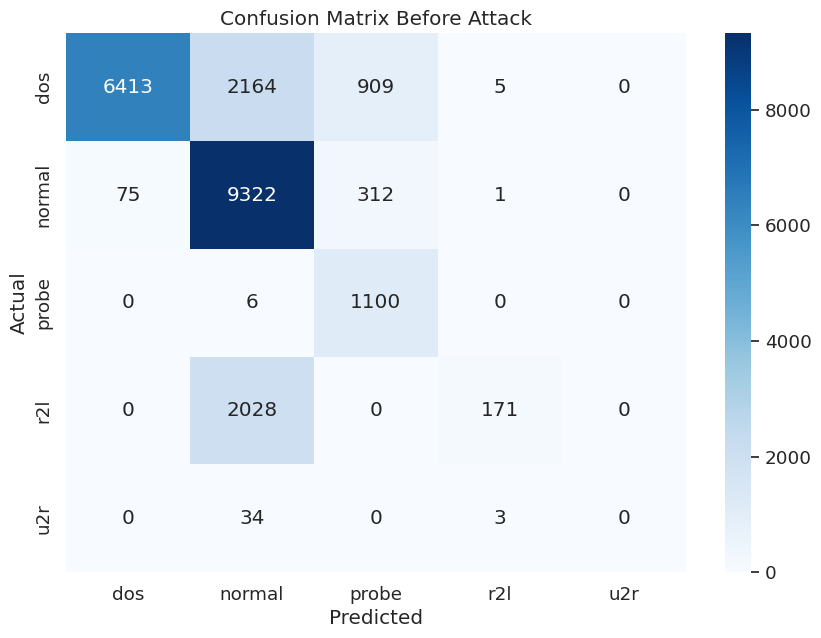

705/705 [==============================] - 1s 871us/step


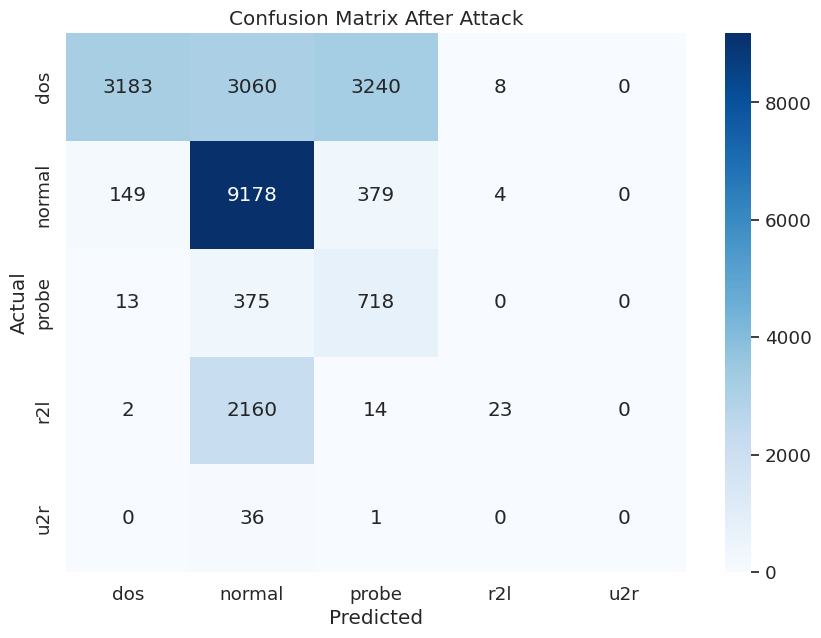

F1 Score Before Attack: 0.7286538744404768
F1 Score After Attack: 0.5461525957218986


In [ ]:

# Function to create a model
def create_model():
    input = Input(shape=(122,))
    x = Dense(64)(input)
    x = Dense(32)(x)
    x = Activation('relu')(x)
    x = Dropout(.15)(x)
    x = Dense(32)(x)
    x = Activation('relu')(x)
    x = Dropout(.15)(x)
    x = Dense(32)(x)
    x = Activation('relu')(x)
    x = Dropout(.15)(x)
    x = Dense(5)(x)
    output = Softmax(axis=-1)(x)
    model = Model(inputs=input, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Adversarial training function
def adversarial_training(x, y, model, epochs, epsilon):
    for epoch in range(epochs):
        perturbations = fast_gradient_method.fast_gradient_method(model, x, epsilon, np.inf)
        x_adv = x + perturbations
        model.fit(np.vstack([x, x_adv]), np.vstack([y, y]), epochs=1, batch_size=32, verbose=0)

# Initialize variables
num_clients = 10
n_rounds = 10
adv_epochs = 10
epsilon = 0.3
labels = ['dos', 'normal', 'probe', 'r2l', 'u2r']

# Federated learning initialization
client_data = split_data(train, target, num_clients)
models = [create_model() for _ in range(num_clients)]

# Main federated learning loop with adversarial training
for round in range(n_rounds):
    print(f"Round {round + 1}/{n_rounds}")
    for i, (x_client, y_client) in enumerate(client_data):
        models[i].fit(x_client, y_client, epochs=1, batch_size=32, verbose=0)
        adversarial_training(x_client, y_client, models[i], adv_epochs, epsilon)

    # Average model weights
    avg_weights = [sum(weights) / num_clients for weights in zip(*[model.get_weights() for model in models])]
    for model in models:
        model.set_weights(avg_weights)

# Model evaluation before and after adversarial training
final_modelB = models[0]
test_labels_tf = tf.convert_to_tensor(y_test, dtype=tf.float32)
y_test_class = np.argmax(y_test, axis=1)

# Before adversarial attack
y_pred_original = final_modelB.predict(test)
y_pred_original_class = np.argmax(y_pred_original, axis=1)
confusion_mtx_before = confusion_matrix(y_test_class, y_pred_original_class)
f1_before = f1_score(y_test_class, y_pred_original_class, average='weighted')

# Plot before adversarial attack
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mtx_before, annot=True, fmt="g", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Before Attack')
plt.show()

# After adversarial attack
adv_images = fast_gradient_method.fast_gradient_method(final_modelB, test, epsilon, np.inf)
y_pred_adv = final_modelB.predict(adv_images)
y_pred_adv_class = np.argmax(y_pred_adv, axis=1)
confusion_mtx_after = confusion_matrix(y_test_class, y_pred_adv_class)
f1_after = f1_score(y_test_class, y_pred_adv_class, average='weighted')

# Plot after adversarial attack
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mtx_after, annot=True, fmt="g", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix After Attack')
plt.show()

print(f"F1 Score Before Attack: {f1_before}")
print(f"F1 Score After Attack: {f1_after}")


## WITHOUT FGSM ROBUSTNESS

In [ ]:
from cleverhans.tf2.attacks import fast_gradient_method
import tensorflow as tf

# Assuming `models[0]` is the final model after federated learning
final_modelA = models[0]
final_modelB = models[0]
final_modelC = models[0]
final_modelD = models[0]
epsilon = 0.3  # You can adjust epsilon to control the magnitude of the attack


Large attack

In [ ]:
# Convert test data to TensorFlow tensors
test_images_tf = tf.convert_to_tensor(test, dtype=tf.float32)
test_labels_tf = tf.convert_to_tensor(y_test, dtype=tf.float32)

# Define the loss function
loss_object = tf.keras.losses.CategoricalCrossentropy()

# Create an FGSM attacker
def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = final_modelA(input_image)
        loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)

    # Get the sign of the gradients to create the perturbation
    perturbation = tf.sign(gradient)
    return perturbation

# Get the adversarial examples
perturbations = create_adversarial_pattern(test_images_tf, test_labels_tf)
adv_images = test_images_tf + epsilon * perturbations

# Evaluate the model on the adversarial examples
loss, accuracy = final_modelA.evaluate(adv_images, test_labels_tf, verbose=0)
print(f"Test loss on adversarial examples: {loss:.4f}")
print(f"Test accuracy on adversarial examples: {accuracy:.4f}")



Test loss on adversarial examples: 8.2795
Test accuracy on adversarial examples: 0.4850


705/705 [==============================] - 1s 2ms/step
Confusion Matrix for FGSM Adversarial Examples:
[[ 942 7708  841    0    0]
 [1010 8525  175    0    0]
 [ 655  451    0    0    0]
 [  85 2114    0    0    0]
 [   2   35    0    0    0]]
F1 Score for FGSM Adversarial Examples: 0.3223917542223483


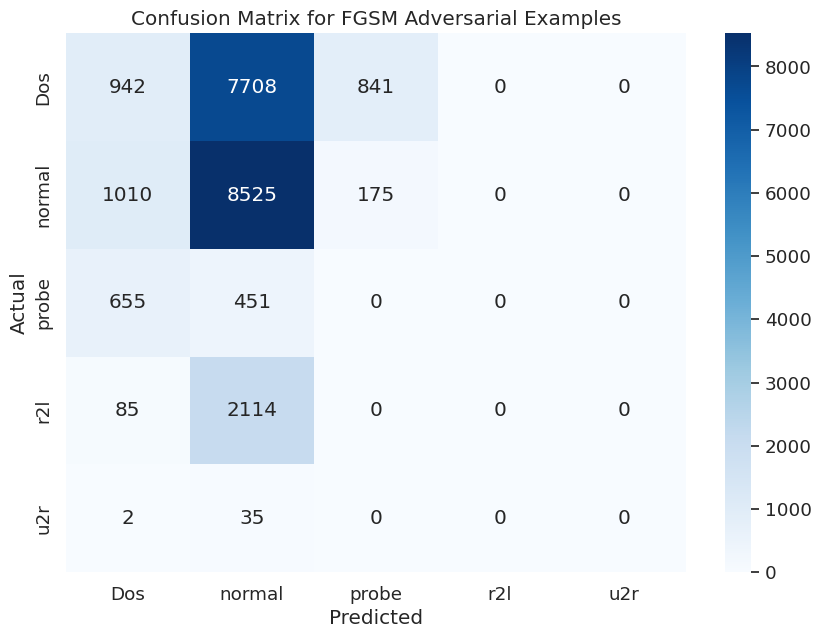

In [ ]:
# Generate predictions for adversarial examples
y_pred_adv = final_modelA.predict(adv_images)

# Convert predicted and true labels to class labels
y_pred_adv_class = np.argmax(y_pred_adv, axis=1)
y_test_adv_class = np.argmax(test_labels_tf, axis=1)

# Generate confusion matrix and F1 score for adversarial examples
confusion_mtx_adv = confusion_matrix(y_test_adv_class, y_pred_adv_class)
f1_adv = f1_score(y_test_adv_class, y_pred_adv_class, average='weighted')

print("Confusion Matrix for FGSM Adversarial Examples:")
print(confusion_mtx_adv)
print(f"F1 Score for FGSM Adversarial Examples: {f1_adv}")

# Plotting the confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.2)
sns.heatmap(confusion_mtx_adv, annot=True, fmt="g", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for FGSM Adversarial Examples')
plt.show()


targetted attack

705/705 [==============================] - 2s 3ms/step
Confusion Matrix for normal examples:
[[5841 2801  849    0    0]
 [ 419 9111  180    0    0]
 [  87   56  963    0    0]
 [   1 2198    0    0    0]
 [   0   37    0    0    0]]


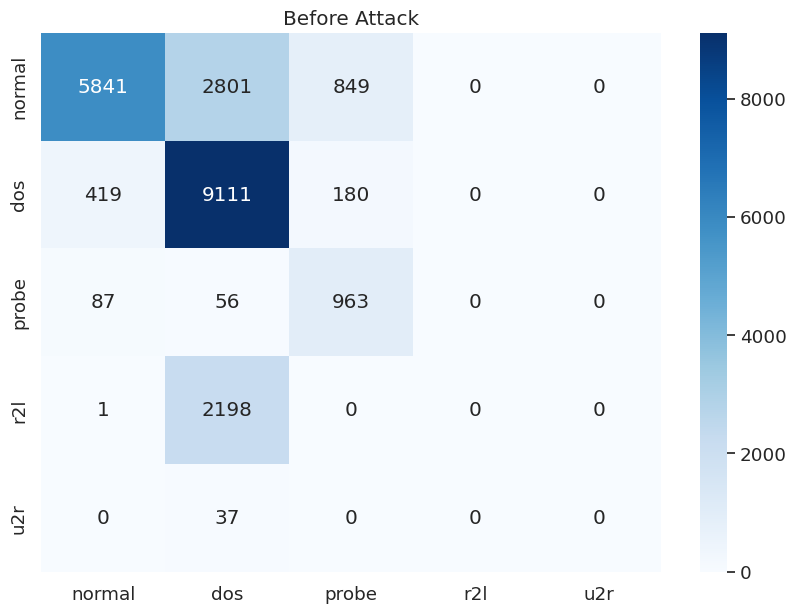

Confusion Matrix for adversarial examples:
[[5131 4327   33    0    0]
 [  90 9617    3    0    0]
 [ 515  462  129    0    0]
 [   0 2199    0    0    0]
 [   0   37    0    0    0]]


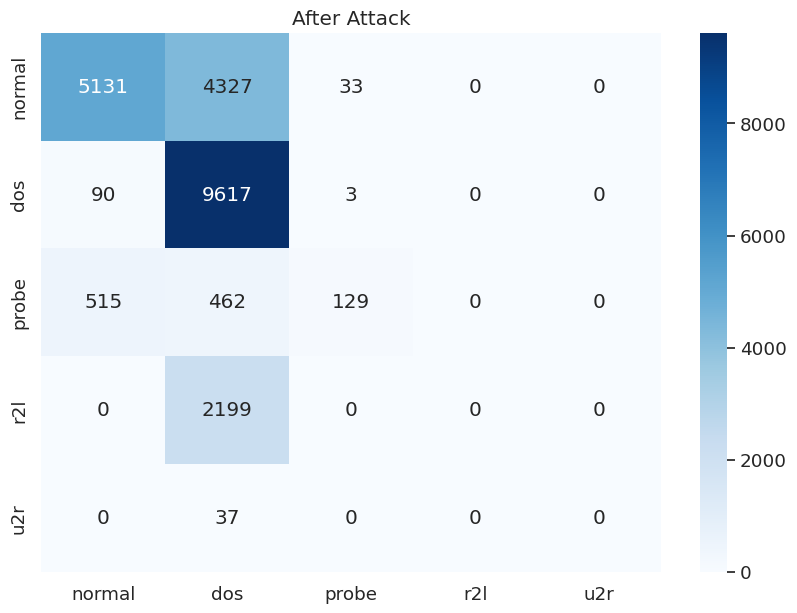

Classification Report for normal examples:
              precision    recall  f1-score   support

     class_0       0.92      0.62      0.74      9491
     class_1       0.64      0.94      0.76      9710
     class_2       0.48      0.87      0.62      1106
     class_3       0.00      0.00      0.00      2199
     class_4       0.00      0.00      0.00        37

    accuracy                           0.71     22543
   macro avg       0.41      0.48      0.42     22543
weighted avg       0.69      0.71      0.67     22543

Classification Report for adversarial examples:
              precision    recall  f1-score   support

     class_0       0.89      0.54      0.67      9491
     class_1       0.58      0.99      0.73      9710
     class_2       0.78      0.12      0.20      1106
     class_3       0.00      0.00      0.00      2199
     class_4       0.00      0.00      0.00        37

    accuracy                           0.66     22543
   macro avg       0.45      0.33      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from cleverhans.tf2.attacks import fast_gradient_method

# Function to create targeted adversarial pattern
def create_targeted_adversarial_pattern(input_image, original_label, target_class_index):
    target_label = np.zeros_like(original_label)
    target_label[:, target_class_index] = 1.0
    target_label_tf = tf.convert_to_tensor(target_label, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = final_modelB(input_image)
        loss = -tf.keras.losses.categorical_crossentropy(target_label_tf, prediction)

    gradient = tape.gradient(loss, input_image)
    perturbation = tf.sign(gradient)
    return perturbation

# Function to evaluate model and attack
def evaluate_attack(model, normal_data, normal_labels, adversarial_data, adversarial_labels):
    y_pred_normal = model.predict(normal_data)
    y_pred_adv = model.predict(adversarial_data)
    y_pred_normal_class = np.argmax(y_pred_normal, axis=1)
    y_pred_adv_class = np.argmax(y_pred_adv, axis=1)
    y_true_class = np.argmax(normal_labels, axis=1)

    confusion_mtx_normal = confusion_matrix(y_true_class, y_pred_normal_class)
    confusion_mtx_adv = confusion_matrix(y_true_class, y_pred_adv_class)

    labels = ['normal', 'dos', 'probe', 'r2l', 'u2r']

    print("Confusion Matrix for normal examples:")
    print(confusion_mtx_normal)
    plt.figure(figsize=(10, 7))
    sns.heatmap(confusion_mtx_normal, annot=True, fmt="g", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title('Before Attack')
    plt.show()

    print("Confusion Matrix for adversarial examples:")
    print(confusion_mtx_adv)
    plt.figure(figsize=(10, 7))
    sns.heatmap(confusion_mtx_adv, annot=True, fmt="g", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title('After Attack')
    plt.show()

    unique_classes = np.unique(y_true_class)
    target_names = [f'class_{i}' for i in unique_classes]

    print("Classification Report for normal examples:")
    print(classification_report(y_true_class, y_pred_normal_class, labels=unique_classes, target_names=target_names))

    print("Classification Report for adversarial examples:")
    print(classification_report(y_true_class, y_pred_adv_class, labels=unique_classes, target_names=target_names))


# Replace this with loading  final model and normal test samples
final_modelB = models[0]  #  final model
normal_images = test  #  test samples for 'normal' behavior
normal_labels = y_test  #  test labels

# Generate adversarial examples targeting 'DoS' (assuming index 1 corresponds to 'DoS')
perturbations = create_targeted_adversarial_pattern(tf.convert_to_tensor(normal_images, dtype=tf.float32), normal_labels, 1)
adv_images = normal_images + 0.1 * perturbations

# Evaluate the attack
evaluate_attack(final_modelB, normal_images, normal_labels, adv_images.numpy(), normal_labels)


## WITH FGSM ROBUSTNESS

In [ ]:
def robust():


  def adversarial_training_step(model, images, labels):
      with tf.GradientTape() as tape:
          tape.watch(images)
          prediction = model(images)
          loss = loss_object(labels, prediction)

      gradients = tape.gradient(loss, images)
      perturbations = epsilon * tf.sign(gradients)
      adv_images = images + perturbations

      # Train the model on both the original and the adversarial examples
      model.train_on_batch(images, labels)
      model.train_on_batch(adv_images, labels)

  # Adversarial training during federated learning
  for round in range(n_rounds):
      print(f"Round {round+1}/{n_rounds}")

      for i in range(num_clients):
          data, labels = client_data[i]
          data_tf = tf.convert_to_tensor(data, dtype=tf.float32)
          labels_tf = tf.convert_to_tensor(labels, dtype=tf.float32)

          adversarial_training_step(models[i], data_tf, labels_tf)

      avg_weights = [sum(weights)/num_clients for weights in zip(*[model.get_weights() for model in models])]

      for model in models:
          model.set_weights(avg_weights)


  # Test the final model on the testing dataset
  loss, accuracy = final_modelC.evaluate(test, y_test, verbose=0)
  print(f"Final test loss: {loss:.4f}")
  print(f"Final test accuracy: {accuracy:.4f}")

robust()

Round 1/10
Round 2/10
Round 3/10
Round 4/10
Round 5/10
Round 6/10
Round 7/10
Round 8/10
Round 9/10
Round 10/10
Final test loss: 0.4878
Final test accuracy: 0.7019


In [ ]:
def attackRobustModel():
  from cleverhans.tf2.attacks import fast_gradient_method
  import tensorflow as tf


  # Convert test data to TensorFlow tensors
  test_images_tf = tf.convert_to_tensor(test, dtype=tf.float32)
  test_labels_tf = tf.convert_to_tensor(y_test, dtype=tf.float32)

  # Define the loss function
  loss_object = tf.keras.losses.CategoricalCrossentropy()

  # Create an FGSM attacker
  def create_adversarial_pattern(input_image, input_label):
      with tf.GradientTape() as tape:
          tape.watch(input_image)
          prediction = final_modelB(input_image)
          loss = loss_object(input_label, prediction)

      # Get the gradients of the loss w.r.t to the input image.
      gradient = tape.gradient(loss, input_image)

      # Get the sign of the gradients to create the perturbation
      perturbation = tf.sign(gradient)
      return perturbation

  # Get the adversarial examples
  perturbations = create_adversarial_pattern(test_images_tf, test_labels_tf)
  adv_images = test_images_tf + epsilon * perturbations

  # Evaluate the model on the adversarial examples
  loss, accuracy = final_modelC.evaluate(adv_images, test_labels_tf, verbose=0)
  print(f"Test loss on adversarial examples: {loss:.4f}")
  print(f"Test accuracy on adversarial examples: {accuracy:.4f}")

  return loss, accuracy

attackRobustModel()

Test loss on adversarial examples: 4.7663
Test accuracy on adversarial examples: 0.4974


(4.766334533691406, 0.49736058712005615)

705/705 [==============================] - 3s 4ms/step
Confusion Matrix for FGSM Adversarial Examples:
[[2117 4541 2833    0    0]
 [ 129 9533   48    0    0]
 [ 380  446  280    0    0]
 [   0 2199    0    0    0]
 [   0   37    0    0    0]]
F1 Score for FGSM Adversarial Examples: 0.4638514097312453


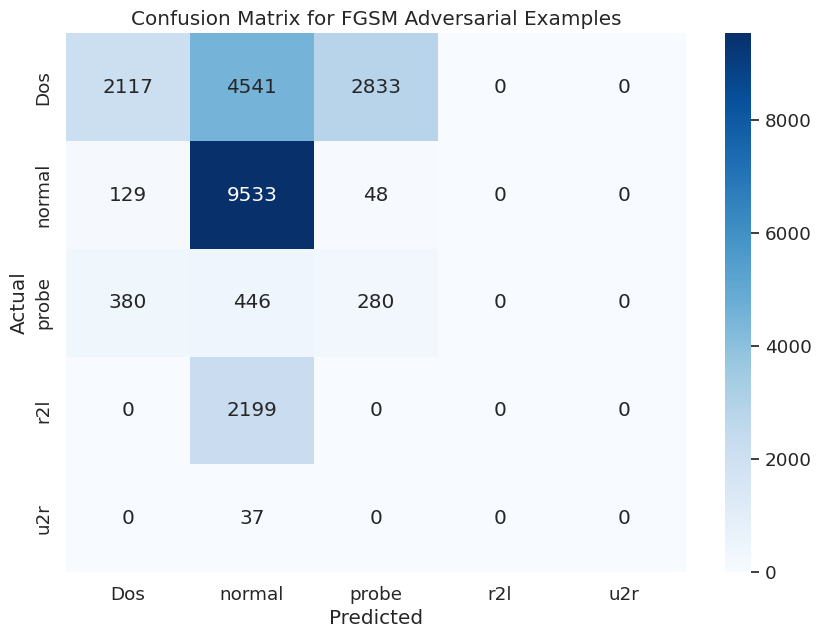

In [ ]:
# Generate predictions for adversarial examples
y_pred_adv = final_modelC.predict(adv_images)

# Convert predicted and true labels to class labels
y_pred_adv_class = np.argmax(y_pred_adv, axis=1)
y_test_adv_class = np.argmax(test_labels_tf, axis=1)

# Generate confusion matrix and F1 score for adversarial examples
confusion_mtx_adv = confusion_matrix(y_test_adv_class, y_pred_adv_class)
f1_adv = f1_score(y_test_adv_class, y_pred_adv_class, average='weighted')

print("Confusion Matrix for FGSM Adversarial Examples:")
print(confusion_mtx_adv)
print(f"F1 Score for FGSM Adversarial Examples: {f1_adv}")

# Plotting the confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.2)
sns.heatmap(confusion_mtx_adv, annot=True, fmt="g", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for FGSM Adversarial Examples')
plt.show()


705/705 [==============================] - 5s 7ms/step
Confusion Matrix for FGSM Adversarial Examples:
[[2117 4541 2833    0    0]
 [ 129 9533   48    0    0]
 [ 380  446  280    0    0]
 [   0 2199    0    0    0]
 [   0   37    0    0    0]]
F1 Score for FGSM Adversarial Examples: 0.4638514097312453


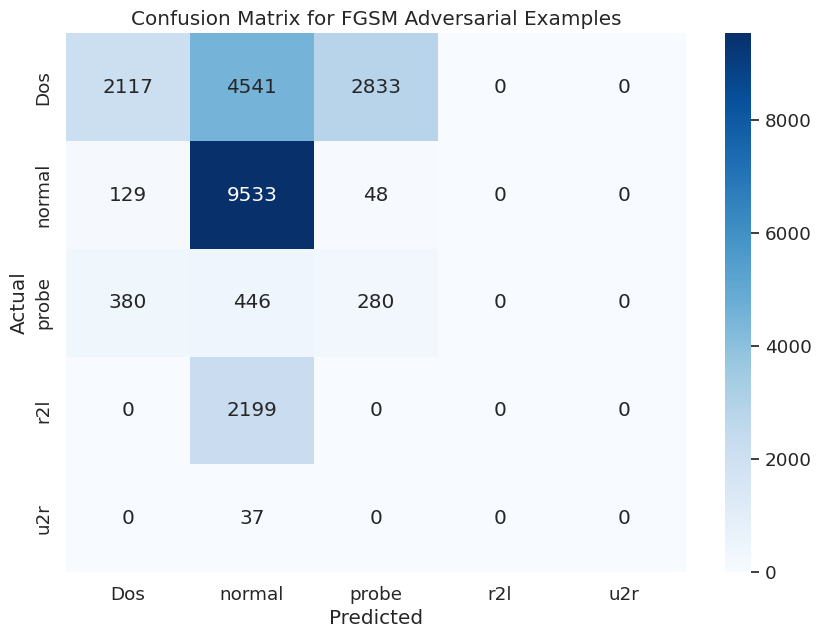

In [ ]:
# Generate predictions for adversarial examples
y_pred_adv = final_modelC.predict(adv_images)

# Convert predicted and true labels to class labels
y_pred_adv_class = np.argmax(y_pred_adv, axis=1)
y_test_adv_class = np.argmax(test_labels_tf, axis=1)

# Generate confusion matrix and F1 score for adversarial examples
confusion_mtx_adv = confusion_matrix(y_test_adv_class, y_pred_adv_class)
f1_adv = f1_score(y_test_adv_class, y_pred_adv_class, average='weighted')

print("Confusion Matrix for FGSM Adversarial Examples:")
print(confusion_mtx_adv)
print(f"F1 Score for FGSM Adversarial Examples: {f1_adv}")

# Plotting the confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.2)
sns.heatmap(confusion_mtx_adv, annot=True, fmt="g", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for FGSM Adversarial Examples')
plt.show()


##Strong Robust Model

In [ ]:
import math
def makeItStronger(reachLoss):
  robust()
  lossR,accuracyR=attackRobustModel()
  if (lossR > reachLoss):
    makeItStronger(reachLoss)
  else:
      print("Strong Model")
      print(f"Test loss on adversarial examples: {lossR:.4f}")
      print(f"Test accuracy on adversarial examples: {accuracyR:.4f}")
  return None;
makeItStronger(0.75)

Round 1/10
Round 2/10
Round 3/10
Round 4/10
Round 5/10
Round 6/10
Round 7/10
Round 8/10
Round 9/10
Round 10/10
Final test loss: 0.6813
Final test accuracy: 0.7067
Test loss on adversarial examples: 3.8392
Test accuracy on adversarial examples: 0.5639
Round 1/10
Round 2/10
Round 3/10
Round 4/10
Round 5/10
Round 6/10
Round 7/10
Round 8/10
Round 9/10
Round 10/10
Final test loss: 0.6188
Final test accuracy: 0.7090
Test loss on adversarial examples: 2.8940
Test accuracy on adversarial examples: 0.5967
Round 1/10
Round 2/10
Round 3/10
Round 4/10
Round 5/10
Round 6/10
Round 7/10
Round 8/10
Round 9/10
Round 10/10
Final test loss: 0.6106
Final test accuracy: 0.7073
Test loss on adversarial examples: 2.6055
Test accuracy on adversarial examples: 0.6091
Round 1/10
Round 2/10
Round 3/10
Round 4/10
Round 5/10
Round 6/10
Round 7/10
Round 8/10
Round 9/10
Round 10/10
Final test loss: 0.5907
Final test accuracy: 0.7010
Test loss on adversarial examples: 2.2096
Test accuracy on adversarial examples: 0.6

KeyboardInterrupt: ignored

#FLOWER SIMULATION

# New Section

# New Section

In [ ]:
!pip install -q flwr[simulation] torch torchvision matplotlib

In [ ]:
#When executing on local environment only -> colab research python3 environment does not require this step
!pip install -U ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.5 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
pip install tensorflow

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import requests
import sys

def your_data_loading_function():
    # URL references
    urls = {
        "field_names": "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/Field%20Names.csv",
        "train_data": 'https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.csv',
        "test_data": 'https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest%2B.csv',
        "attack_types": "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/Attack%20Types.csv"
    }

    # Data fetching and preprocessing
    try:
        url = urls["field_names"]
        kdd_names_df = pd.read_csv(url, header=None)
        kdd_cols = kdd_names_df[0].str.split(':', expand=True)[0].str.strip().tolist()
        kdd_cols += ['class', 'difficulty']
    except Exception as e:
        print(f"Error fetching field names: {e}")
        sys.exit(1)

    try:
        kdd = pd.read_csv(urls["train_data"], header=None)
        kdd_t = pd.read_csv(urls["test_data"], header=None)
    except pd.errors.EmptyDataError as e:
        print(f"No data: {e}")
        sys.exit(1)
    except pd.errors.ParserError as e:
        print(f"Error parsing data: {e}")
        sys.exit(1)
    except Exception as e:
        print(f"An error occurred during data fetching: {e}")
        sys.exit(1)

    # Fetching attack map and replacing class labels
    try:
        response = requests.get(urls["attack_types"])
        response_content = response.text.replace('\r', '\n')
        lines = [x.strip().split(',') for x in response_content.split('\n') if x]
        attack_map = {k: v for k, v in lines}
    except Exception as e:
        print(f"Error fetching attack map: {e}")
        sys.exit(1)

    # Data preprocessing
    kdd.columns = kdd_cols
    kdd_t.columns = kdd_cols

    kdd['class'] = kdd['class'].replace(attack_map)
    kdd_t['class'] = kdd_t['class'].replace(attack_map)

    def cat_encode(df, col):
        return pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col].values, prefix=col)], axis=1)

    def log_trns(df, col):
        return df[col].apply(np.log1p)

    cat_lst = ['protocol_type', 'service', 'flag']
    for col in cat_lst:
        kdd = cat_encode(kdd, col)
        kdd_t = cat_encode(kdd_t, col)

    log_lst = ['duration', 'src_bytes', 'dst_bytes']
    for col in log_lst:
        kdd[col] = log_trns(kdd, col)
        kdd_t[col] = log_trns(kdd_t, col)

    kdd, kdd_t = kdd.align(kdd_t, axis=1, fill_value=0)

    difficulty = kdd.pop('difficulty')
    target = kdd.pop('class')
    y_diff = kdd_t.pop('difficulty')
    y_test = kdd_t.pop('class')

    target = pd.get_dummies(target)
    y_test = pd.get_dummies(y_test)

    df = pd.DataFrame(y_test)
    y_test = df[['dos', 'normal', 'probe','r2l', 'u2r']]

    target = target.values
    train = kdd.values
    test = kdd_t.values
    y_test = y_test.values

    min_max_scaler = MinMaxScaler()
    train = min_max_scaler.fit_transform(train)
    test = min_max_scaler.transform(test)

    return (train, target), (test, y_test)


In [ ]:
from flwr.server import SimpleClientManager
import flwr as fl
import torch
from torch import nn
from sklearn.metrics import confusion_matrix, f1_score
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split, TensorDataset
from collections import OrderedDict
from typing import List, Tuple, Dict, Optional
import pandas as pd
import math
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
import io


#Define a Metrics type alias
Metrics = Dict[str, float]

#Utility function to round a number to the upper value
def round_up(n, decimals=0):
    multiplier = 10**decimals
    return math.ceil(n * multiplier) / multiplier


# Load and preprocess data , and split it into train and test sets
(train, target), (test, y_test) = your_data_loading_function()

# Transform data to the good data type
train = torch.from_numpy(train).to(torch.float)
target = torch.from_numpy(target).to(torch.float)
test = torch.from_numpy(test).to(torch.float)
y_test = torch.from_numpy(y_test).to(torch.float)


def split_data(data, labels, num_clients):
    """Splits data and labels into num_clients parts."""
    client_data = []
    data_size = len(data) // num_clients
    for i in range(num_clients):
        data_start = i * data_size
        data_end = (i + 1) * data_size if i != num_clients - 1 else None
        client_data.append((data[data_start:data_end], labels[data_start:data_end]))
    return client_data

num_clients = 5
client_data = split_data(train, target, num_clients)

def create_model():
    model = nn.Sequential(
        nn.Linear(122, 64),
        nn.ReLU(),
        nn.Dropout(0.15),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(0.15),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Dropout(0.15),
        nn.Linear(32, 5)
    )
    return model


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def train(net, loader, epochs=1):
    optimizer = Adam(net.parameters())
    loss_fn = nn.CrossEntropyLoss() #nn.BCEWithLogitsLoss()
    for _ in range(epochs):
        for batch in loader:
            data, target = batch
            #print(target[:5]) #To debug target
            optimizer.zero_grad()
            output = net(data)
            #print("#####DEBUG TRAIN FABIEN Sechi#########",output.dtype, target.dtype)  # To debug the data types
            loss = loss_fn(output, target.float())
            loss.backward()
            optimizer.step()

def test(net, loader):
    loss_fn = nn.CrossEntropyLoss() #nn.BCEWithLogitsLoss()
    loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in loader:
            data, target = batch
            output = net(data)
            loss += loss_fn(output, target.float()).item()
            pred = torch.argmax(output, dim=1)
            correct += pred.eq(target.argmax(dim=1)).sum().item()
            total += target.size(0)
    loss /= len(loader.dataset)
    accuracy = correct / total
    return loss, accuracy

class Client(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        loss, accuracy = test(self.net, self.trainloader)
        metrics = {"train_loss": float(loss), "train_accuracy": float(accuracy)}
        #print("METRICS",metrics)
        return get_parameters(self.net), len(self.trainloader), metrics


    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

#############################################
###Initialization of the Flower Simulation###
#############################################
def aggregate_fit_metrics(metrics):
   # print(metrics)
    train_loss_acc=0
    train_accuracy_acc=0
    for metric in metrics:
      num_samples = metric[0]
      train_loss = metric[1]['train_loss']
      train_accuracy = metric[1]['train_accuracy']
      train_loss_acc += train_loss
      train_accuracy_acc +=  train_accuracy
     # print(f'Number of samples: {num_samples}')
     # print(f'Train loss: {train_loss}')
     # print(f'Train accuracy: {train_accuracy}')
     # print('----------')
    # Assuming metrics is a list of tuples with structure (num_samples, train_loss, train_accuracy)
    total_samples = num_clients
    weighted_loss = train_loss_acc / total_samples
    weighted_accuracy = train_accuracy_acc/ total_samples
    return {"train_loss": weighted_loss, "train_accuracy": weighted_accuracy}

#To evaluate the metrics aggregation we use wieighted average
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]
    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

# Xlient resources is specified if thr GPU is needed (defaults to 1 CPU and 0 GPU)
client_resources = None
DEVICE = torch.device("cpu")  # Nvidia "cuda" to train on GPU -> not available on my environment
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}



# The `evaluate` function will be by Flower called after every round
def evaluate(server_round: int, parameters: fl.common.NDArrays, config: Dict[str, fl.common.Scalar]) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    net = create_model().to(DEVICE)

    # Create data loaders for training and validation
    train_data, val_data, train_target, val_target = train_test_split(test, y_test, test_size=0.2)

    train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_data).float(), torch.tensor(train_target).float())
    val_dataset = torch.utils.data.TensorDataset(torch.tensor(val_data).float(), torch.tensor(val_target).float())

    trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, valloader)

    print(f"Server-side evaluation at round {server_round}: loss={loss:.4f}, accuracy={accuracy:.4f}")

    return loss, {"accuracy": accuracy}



# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=num_clients,
    min_evaluate_clients=int(round_up(num_clients/2)),
    min_available_clients=num_clients,
    evaluate_metrics_aggregation_fn=weighted_average,
    fit_metrics_aggregation_fn=aggregate_fit_metrics,
    initial_parameters=fl.common.ndarrays_to_parameters(get_parameters(create_model())),# Create an instance of the model and get the parameters
  #  evaluate_fn=evaluate,  # Pass the evaluation function
)

#Client behaviour with subset of the data
def client_fn(cid: str) -> Client:
    # Create a new client with a subset of the data
    data, target = client_data[int(cid)]

    # Create data loaders for training and validation
    train_data, val_data, train_target, val_target = train_test_split(data, target, test_size=0.2)

    train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_data).float(), torch.tensor(train_target).float())
    val_dataset = torch.utils.data.TensorDataset(torch.tensor(val_data).float(), torch.tensor(val_target).float())

    trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize a new instance of neural network model
    net = create_model()

    return Client(net, trainloader, valloader)


###############################
### Start Flower simulation ###
###############################

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=num_clients,
    config=fl.server.ServerConfig(num_rounds=3,round_timeout=180), #10 rounds and no more than 3 minutes per round
    strategy=strategy,
    client_resources=client_resources
)

#Init clients and server for real settings and no simulation
#server = fl.server.Server(strategy=strategy, client_manager=SimpleClientManager())
# Initialize Flower clients
#clients = [SimpleClient(create_model(), data, target) for data, target in client_data]

INFO flwr 2023-11-14 15:43:29,079 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=180)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=180)


Training on cpu using PyTorch 2.1.0+cu118 and Flower 1.5.0


2023-11-14 15:43:35,780	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-11-14 15:43:39,857 | app.py:210 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7853875200.0, 'object_store_memory': 3926937600.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7853875200.0, 'object_store_memory': 3926937600.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO flwr 2023-11-14 15:43:39,865 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-11-14 15:43:39,872 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO:flwr:Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2023-11-14 15:43:39,926 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool

History (loss, distributed):
	round 1: 0.0035650268780665676
	round 2: 0.0026311836348522862
	round 3: 0.0017609372290625538
History (metrics, distributed, fit):
{'train_loss': [(1, 0.0033140142247467357), (2, 0.002373795794121206), (3, 0.0017048671631520857)], 'train_accuracy': [(1, 0.9730891287811418), (2, 0.9765025507346097), (3, 0.9825059027147928)]}History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.9714908633295218), (2, 0.9747321159506115), (3, 0.9809498871763209)]}

In [ ]:
from flwr.server import SimpleClientManager
import flwr as fl
import torch
from torch import nn
from sklearn.metrics import confusion_matrix, f1_score
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split, TensorDataset
from collections import OrderedDict
from typing import List, Tuple, Dict, Optional
import pandas as pd
import math
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
import io


#Define a Metrics type alias
Metrics = Dict[str, float]

#Utility function to round a number to the upper value
def round_up(n, decimals=0):
    multiplier = 10**decimals
    return math.ceil(n * multiplier) / multiplier


# Load and preprocess data , and split it into train and test sets
(train, target), (test, y_test) = your_data_loading_function()

# Transform data to the good data type
train = torch.from_numpy(train).to(torch.float)
target = torch.from_numpy(target).to(torch.float)
test = torch.from_numpy(test).to(torch.float)
y_test = torch.from_numpy(y_test).to(torch.float)


def split_data(data, labels, num_clients):
    """Splits data and labels into num_clients parts."""
    client_data = []
    data_size = len(data) // num_clients
    for i in range(num_clients):
        data_start = i * data_size
        data_end = (i + 1) * data_size if i != num_clients - 1 else None
        client_data.append((data[data_start:data_end], labels[data_start:data_end]))
    return client_data

num_clients = 5
client_data = split_data(train, target, num_clients)

def create_model():
    model = nn.Sequential(
        nn.Linear(122, 64),
        nn.ReLU(),
        nn.Dropout(0.15),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(0.15),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Dropout(0.15),
        nn.Linear(32, 5)
    )
    return model


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def train(net, loader, epochs=1):
    optimizer = Adam(net.parameters())
    loss_fn = nn.CrossEntropyLoss() #nn.BCEWithLogitsLoss()
    for _ in range(epochs):
        for batch in loader:
            data, target = batch
            #print(target[:5]) #To debug target
            optimizer.zero_grad()
            output = net(data)
            #print("#####DEBUG TRAIN FABIEN Sechi#########",output.dtype, target.dtype)  # To debug the data types
            loss = loss_fn(output, target.float())
            loss.backward()
            optimizer.step()

def test(net, loader):
    loss_fn = nn.CrossEntropyLoss() #nn.BCEWithLogitsLoss()
    loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in loader:
            data, target = batch
            output = net(data)
            loss += loss_fn(output, target.float()).item()
            pred = torch.argmax(output, dim=1)
            correct += pred.eq(target.argmax(dim=1)).sum().item()
            total += target.size(0)
    loss /= len(loader.dataset)
    accuracy = correct / total
    return loss, accuracy

class Client(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        loss, accuracy = test(self.net, self.trainloader)
        metrics = {"train_loss": float(loss), "train_accuracy": float(accuracy)}
        #print("METRICS",metrics)
        return get_parameters(self.net), len(self.trainloader), metrics


    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

#############################################
###Initialization of the Flower Simulation###
#############################################
def aggregate_fit_metrics(metrics):
   # print(metrics)
    train_loss_acc=0
    train_accuracy_acc=0
    for metric in metrics:
      num_samples = metric[0]
      train_loss = metric[1]['train_loss']
      train_accuracy = metric[1]['train_accuracy']
      train_loss_acc += train_loss
      train_accuracy_acc +=  train_accuracy
     # print(f'Number of samples: {num_samples}')
     # print(f'Train loss: {train_loss}')
     # print(f'Train accuracy: {train_accuracy}')
     # print('----------')
    # Assuming metrics is a list of tuples with structure (num_samples, train_loss, train_accuracy)
    total_samples = num_clients
    weighted_loss = train_loss_acc / total_samples
    weighted_accuracy = train_accuracy_acc/ total_samples
    return {"train_loss": weighted_loss, "train_accuracy": weighted_accuracy}

#To evaluate the metrics aggregation we use wieighted average
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]
    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

# Xlient resources is specified if thr GPU is needed (defaults to 1 CPU and 0 GPU)
client_resources = None
DEVICE = torch.device("cpu")  # Nvidia "cuda" to train on GPU -> not available on my environment
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}



# The `evaluate` function will be by Flower called after every round
def evaluate(server_round: int, parameters: fl.common.NDArrays, config: Dict[str, fl.common.Scalar]) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    net = create_model().to(DEVICE)



    # Creating a DataLoader for evaluation using the test data
    test_dataset = TensorDataset(test, y_test)
    valloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, valloader)

    print(f"Server-side evaluation at round {server_round}: loss={loss:.4f}, accuracy={accuracy:.4f}")

    return loss, {"accuracy": accuracy}



# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=num_clients,
    min_evaluate_clients=int(round_up(num_clients/2)),
    min_available_clients=num_clients,
    evaluate_metrics_aggregation_fn=weighted_average,
    fit_metrics_aggregation_fn=aggregate_fit_metrics,
    initial_parameters=fl.common.ndarrays_to_parameters(get_parameters(create_model())),# Create an instance of the model and get the parameters
    evaluate_fn=evaluate,  # Pass the evaluation function
)

#Client behaviour with subset of the data
def client_fn(cid: str) -> Client:
    # Create a new client with a subset of the data
    data, target = client_data[int(cid)]

    # Create data loaders for training and validation
    train_data, val_data, train_target, val_target = train_test_split(data, target, test_size=0.2)

    train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_data).float(), torch.tensor(train_target).float())
    val_dataset = torch.utils.data.TensorDataset(torch.tensor(val_data).float(), torch.tensor(val_target).float())

    trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize a new instance of neural network model
    net = create_model()

    return Client(net, trainloader, valloader)


###############################
### Start Flower simulation ###
###############################

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=num_clients,
    config=fl.server.ServerConfig(num_rounds=3,round_timeout=180), #10 rounds and no more than 3 minutes per round
    strategy=strategy,
    client_resources=client_resources
)

#Init clients and server for real settings and no simulation
#server = fl.server.Server(strategy=strategy, client_manager=SimpleClientManager())
# Initialize Flower clients
#clients = [SimpleClient(create_model(), data, target) for data, target in client_data]

In [ ]:
from flwr.server import SimpleClientManager
import flwr as fl
import torch
from torch import nn
from sklearn.metrics import confusion_matrix, f1_score
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split, TensorDataset
from collections import OrderedDict
from typing import List, Tuple, Dict, Optional
import pandas as pd
import math
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
import io


#Define a Metrics type alias
Metrics = Dict[str, float]

#Utility function to round a number to the upper value
def round_up(n, decimals=0):
    multiplier = 10**decimals
    return math.ceil(n * multiplier) / multiplier


# Load and preprocess data , and split it into train and test sets
(train, target), (test, y_test) = your_data_loading_function()

# Transform data to the good data type
train = torch.from_numpy(train).to(torch.float)
target = torch.from_numpy(target).to(torch.float)
test = torch.from_numpy(test).to(torch.float)
y_test = torch.from_numpy(y_test).to(torch.float)


def split_data(data, labels, num_clients):
    """Splits data and labels into num_clients parts."""
    client_data = []
    data_size = len(data) // num_clients
    for i in range(num_clients):
        data_start = i * data_size
        data_end = (i + 1) * data_size if i != num_clients - 1 else None
        client_data.append((data[data_start:data_end], labels[data_start:data_end]))
    return client_data

num_clients = 5
client_data = split_data(train, target, num_clients)

def create_model():
    model = nn.Sequential(
        nn.Linear(122, 64),
        nn.ReLU(),
        nn.Dropout(0.15),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(0.15),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Dropout(0.15),
        nn.Linear(32, 5)
    )
    return model


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def train(net, loader, epochs=1):
    optimizer = Adam(net.parameters())
    loss_fn = nn.CrossEntropyLoss() #nn.BCEWithLogitsLoss()
    for _ in range(epochs):
        for batch in loader:
            data, target = batch
            #print(target[:5]) #To debug target
            optimizer.zero_grad()
            output = net(data)
            #print("#####DEBUG TRAIN FABIEN Sechi#########",output.dtype, target.dtype)  # To debug the data types
            loss = loss_fn(output, target.float())
            loss.backward()
            optimizer.step()

def test(net, loader):
    loss_fn = nn.CrossEntropyLoss() #nn.BCEWithLogitsLoss()
    loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in loader:
            data, target = batch
            output = net(data)
            loss += loss_fn(output, target.float()).item()
            pred = torch.argmax(output, dim=1)
            correct += pred.eq(target.argmax(dim=1)).sum().item()
            total += target.size(0)
    loss /= len(loader.dataset)
    accuracy = correct / total
    return loss, accuracy

class Client(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        loss, accuracy = test(self.net, self.trainloader)
        metrics = {"train_loss": float(loss), "train_accuracy": float(accuracy)}
        #print("METRICS",metrics)
        return get_parameters(self.net), len(self.trainloader), metrics


    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

#############################################
###Initialization of the Flower Simulation###
#############################################
def aggregate_fit_metrics(metrics):
   # print(metrics)
    train_loss_acc=0
    train_accuracy_acc=0
    for metric in metrics:
      num_samples = metric[0]
      train_loss = metric[1]['train_loss']
      train_accuracy = metric[1]['train_accuracy']
      train_loss_acc += train_loss
      train_accuracy_acc +=  train_accuracy
     # print(f'Number of samples: {num_samples}')
     # print(f'Train loss: {train_loss}')
     # print(f'Train accuracy: {train_accuracy}')
     # print('----------')
    # Assuming metrics is a list of tuples with structure (num_samples, train_loss, train_accuracy)
    total_samples = num_clients
    weighted_loss = train_loss_acc / total_samples
    weighted_accuracy = train_accuracy_acc/ total_samples
    return {"train_loss": weighted_loss, "train_accuracy": weighted_accuracy}

#To evaluate the metrics aggregation we use wieighted average
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]
    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

# Xlient resources is specified if thr GPU is needed (defaults to 1 CPU and 0 GPU)
client_resources = None
DEVICE = torch.device("cpu")  # Nvidia "cuda" to train on GPU -> not available on my environment
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}



# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=num_clients,
    min_evaluate_clients=int(round_up(num_clients/2)),
    min_available_clients=num_clients,
    evaluate_metrics_aggregation_fn=weighted_average,
    fit_metrics_aggregation_fn=aggregate_fit_metrics,
    initial_parameters=fl.common.ndarrays_to_parameters(get_parameters(create_model())),# Create an instance of the model and get the parameters
    evaluate_fn=evaluate,  # Pass the evaluation function
)

#Client behaviour with subset of the data
def client_fn(cid: str) -> Client:
    # Create a new client with a subset of the data
    data, target = client_data[int(cid)]

    # Create data loaders for training and validation
    train_data, val_data, train_target, val_target = train_test_split(data, target, test_size=0.2)

    train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_data).float(), torch.tensor(train_target).float())
    val_dataset = torch.utils.data.TensorDataset(torch.tensor(val_data).float(), torch.tensor(val_target).float())

    trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize a new instance of neural network model
    net = create_model()

    return Client(net, trainloader, valloader)


###############################
### Start Flower simulation ###
###############################

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=num_clients,
    config=fl.server.ServerConfig(num_rounds=3,round_timeout=180), #10 rounds and no more than 3 minutes per round
    strategy=strategy,
    client_resources=client_resources
)

#Init clients and server for real settings and no simulation
#server = fl.server.Server(strategy=strategy, client_manager=SimpleClientManager())
# Initialize Flower clients
#clients = [SimpleClient(create_model(), data, target) for data, target in client_data]

In [ ]:
from flwr.server import SimpleClientManager
import flwr as fl
import torch
from torch import nn
from sklearn.metrics import confusion_matrix, f1_score
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split, TensorDataset
from collections import OrderedDict
from typing import List, Tuple, Dict, Optional
import pandas as pd
import math
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
import io


#Define a Metrics type alias
Metrics = Dict[str, float]

#Utility function to round a number to the upper value
def round_up(n, decimals=0):
    multiplier = 10**decimals
    return math.ceil(n * multiplier) / multiplier


# Load and preprocess data , and split it into train and test sets
(train, target), (test, y_test) = your_data_loading_function()

# Transform data to the good data type
train = torch.from_numpy(train).to(torch.float)
target = torch.from_numpy(target).to(torch.float)
test = torch.from_numpy(test).to(torch.float)
y_test = torch.from_numpy(y_test).to(torch.float)


def split_data(data, labels, num_clients):
    """Splits data and labels into num_clients parts."""
    client_data = []
    data_size = len(data) // num_clients
    for i in range(num_clients):
        data_start = i * data_size
        data_end = (i + 1) * data_size if i != num_clients - 1 else None
        client_data.append((data[data_start:data_end], labels[data_start:data_end]))
    return client_data

num_clients = 5
client_data = split_data(train, target, num_clients)

def create_model():
    model = nn.Sequential(
        nn.Linear(122, 64),
        nn.ReLU(),
        nn.Dropout(0.15),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(0.15),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Dropout(0.15),
        nn.Linear(32, 5)
    )
    return model


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def train(net, loader, epochs=1):
    optimizer = Adam(net.parameters())
    loss_fn = nn.CrossEntropyLoss() #nn.BCEWithLogitsLoss()
    for _ in range(epochs):
        for batch in loader:
            data, target = batch
            #print(target[:5]) #To debug target
            optimizer.zero_grad()
            output = net(data)
            #print("#####DEBUG TRAIN FABIEN Sechi#########",output.dtype, target.dtype)  # To debug the data types
            loss = loss_fn(output, target.float())
            loss.backward()
            optimizer.step()

def test(net, loader):
    loss_fn = nn.CrossEntropyLoss() #nn.BCEWithLogitsLoss()
    loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in loader:
            data, target = batch
            output = net(data)
            loss += loss_fn(output, target.float()).item()
            pred = torch.argmax(output, dim=1)
            correct += pred.eq(target.argmax(dim=1)).sum().item()
            total += target.size(0)
    loss /= len(loader.dataset)
    accuracy = correct / total
    return loss, accuracy

class Client(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        loss, accuracy = test(self.net, self.trainloader)
        metrics = {"train_loss": float(loss), "train_accuracy": float(accuracy)}
        #print("METRICS",metrics)
        return get_parameters(self.net), len(self.trainloader), metrics


    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

#############################################
###Initialization of the Flower Simulation###
#############################################


# The `evaluate` function will be by Flower called after every round
def evaluate(
    server_round: int,
    parameters: fl.common.NDArrays,
    config: Dict[str, fl.common.Scalar],
) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    net = create_model().to(DEVICE)
    valloader = valloaders[0]
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, valloader)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    return loss, {"accuracy": accuracy}


def aggregate_fit_metrics(metrics):
   # print(metrics)
    train_loss_acc=0
    train_accuracy_acc=0
    for metric in metrics:
      num_samples = metric[0]
      train_loss = metric[1]['train_loss']
      train_accuracy = metric[1]['train_accuracy']
      train_loss_acc += train_loss
      train_accuracy_acc +=  train_accuracy
     # print(f'Number of samples: {num_samples}')
     # print(f'Train loss: {train_loss}')
     # print(f'Train accuracy: {train_accuracy}')
     # print('----------')
    # Assuming metrics is a list of tuples with structure (num_samples, train_loss, train_accuracy)
    total_samples = num_clients
    weighted_loss = train_loss_acc / total_samples
    weighted_accuracy = train_accuracy_acc/ total_samples
    return {"train_loss": weighted_loss, "train_accuracy": weighted_accuracy}

#To evaluate the metrics aggregation we use wieighted average
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]
    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

# Xlient resources is specified if thr GPU is needed (defaults to 1 CPU and 0 GPU)
client_resources = None
DEVICE = torch.device("cpu")  # Nvidia "cuda" to train on GPU -> not available on my environment
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}






# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=num_clients,
    min_evaluate_clients=int(round_up(num_clients/2)),
    min_available_clients=num_clients,
    evaluate_metrics_aggregation_fn=weighted_average,
    fit_metrics_aggregation_fn=aggregate_fit_metrics,
    initial_parameters=fl.common.ndarrays_to_parameters(get_parameters(create_model())),# Create an instance of the model and get the parameters
    evaluate_fn=evaluate,  # Pass the evaluation function
)

#Client behaviour with subset of the data
def client_fn(cid: str) -> Client:
    # Create a new client with a subset of the data
    data, target = client_data[int(cid)]

    # Create data loaders for training and validation
    train_data, val_data, train_target, val_target = train_test_split(data, target, test_size=0.2)

    train_dataset = torch.utils.data.TensorDataset(train_data.clone().detach().float(), train_target.clone().detach().float())
    val_dataset = torch.utils.data.TensorDataset(val_data.clone().detach().float(), val_target.clone().detach().float())

    trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize a new instance of neural network model
    net = create_model()

    return Client(net, trainloader, valloader)


###############################
### Start Flower simulation ###
###############################

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=num_clients,
    config=fl.server.ServerConfig(num_rounds=3,round_timeout=180), #10 rounds and no more than 3 minutes per round
    strategy=strategy,
    client_resources=client_resources
)

#Init clients and server for real settings and no simulation
#server = fl.server.Server(strategy=strategy, client_manager=SimpleClientManager())
# Initialize Flower clients
#clients = [SimpleClient(create_model(), data, target) for data, target in client_data]